# Investigation of 3-band MoS2

The model is taken from [1305.6089](http://arxiv.org/abs/1305.6089)

In [1]:
import kwant
import numpy as np
from types import SimpleNamespace
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

import os
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
try:
    import mkl
    mkl.set_num_threads(1)
except:
    pass

import tinyarray as ta
s0 = ta.array([[1,0], [0,1]])
s1 = ta.array([[0,1], [1,0]])
s2 = ta.array([[0, -1j],[1j, 0]])
s3 = ta.array([[1,0], [0, -1]])

In [3]:
import Mod.MoS2_3band as H
import Mod.kp_4bnd as kp4

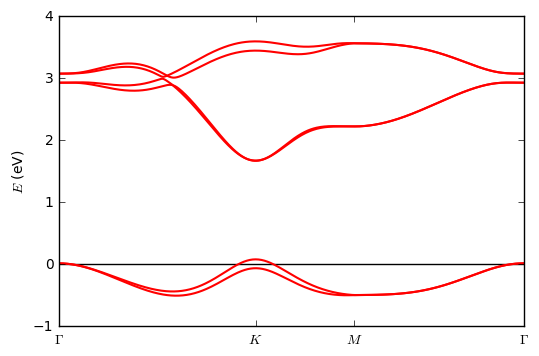

In [4]:
p = SimpleNamespace(B=0., theta=0., lam=.073, mu=0., bso=0.0003, delta=2e-4)
H.plot_spec(p, sc=False)

## Comparison with k.p

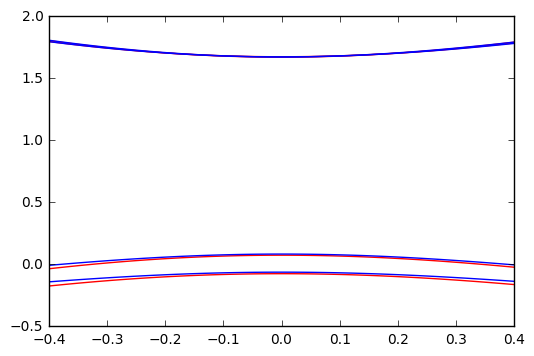

In [6]:
# Before fit
K = (4*np.pi/3, 0)
p.lam = 0.073
p.bso = 0.
p.mu = 0.
# along G-K line
qxs = np.linspace(-0.4, 0.4, 100)
qys = np.zeros_like(qxs)

energy_kp = [kp4.bands_kp(q1, q2) for (q1, q2) in zip(qxs, qys)]
energy_tb = [H.spectrum(0.5*(K[0]+q1), 0.5*np.sqrt(3)*(K[1]+q2), p)[:4] for (q1, q2) in zip(qxs, qys)]

plt.xlim(qxs.min(), qxs.max())
plt.plot(qxs, energy_kp, 'r-')
plt.plot(qxs, energy_tb, 'b-')
plt.show()

In [7]:
# Fit function
qxs = np.linspace(-0.4, 0.4, 100)
qys = np.linspace(-0.4, 0.4, 100)

xs, ys = np.meshgrid(qxs, qys)

# K point
K = (4*np.pi/3, 0)
p.lam = 0.073

def fit_func(x):
    p.bso = x
    return np.asarray([np.abs(kp4.bands_kp(q1, q2)**2-H.spectrum(0.5*(K[0]+q1), 0.5*np.sqrt(3)*(K[1]+q2), p)[:4]**2)
            for (q1, q2) in zip(xs.ravel(), ys.ravel())]).sum()

In [8]:
# find KM spin-orbit coupling 
leastsq(fit_func, 0.)

(array([ 0.00030109]), 1)

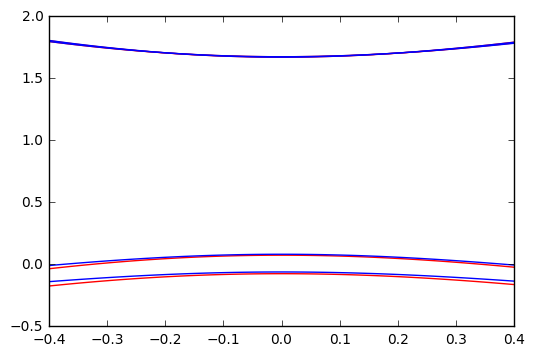

In [11]:
# After fitting
# K point
K = (4*np.pi/3, 0)
p.lam = 0.073
p.bso = 0.0003
# along G-K line
qxs = np.linspace(-0.4, 0.4, 100)
qys = np.zeros_like(qxs)

energy_kp = [kp4.bands_kp(q1, q2) for (q1, q2) in zip(qxs, qys)]
energy_tb = [H.spectrum(0.5*(K[0]+q1), 0.5*np.sqrt(3)*(K[1]+q2), p)[:4] for (q1, q2) in zip(qxs, qys)]
plt.xlim(qxs.min(), qxs.max())
plt.plot(qxs, energy_kp, 'r-')
plt.plot(qxs, energy_tb, 'b-')
plt.show()

# K.P Hamiltonian

In [1]:
import Mod.kp_2bnd as kp2

In [ ]:
kp2.crossings(0., 0, na=5000)

In [ ]:
Delta = .8e-3
def plot_conduction(k2, mu, amin=-0.4, amax=0.4, na = 200):
    """Plots conduction bands and crossings for normal system.
    """
    def energy(k1, k2, mu):
        lam = (kp2.beta+kp2.A1*(k1**2+k2**2)+kp2.A2*k1*(k1**2-3*k2**2))
        xi = kp2.t*k1**2+kp2.t*k2**2+kp2.f0-mu
        return xi+lam, xi-lam
    
    
    k1s = np.linspace(amin, amax, na)

    # the split conduction bands are 2, 3
    ergs = np.asarray([kp2.spectrum(k1, k2, mu, V=0., sc=False) for k1 in k1s]).reshape((na, 2))

    ergs1 = [energy(k1, k2, mu)[0] for k1 in k1s]
    ergs2 = [energy(k1, k2, mu)[1] for k1 in k1s]

    # conduction bands
    c1 = ergs[:, 0]
    c2 = ergs[:, 1]

    # identifying the crossings
    cross1 = np.argwhere((c2-c1) == np.min((c2-c1)[k1s < 0]))
    cross2 = np.argwhere((c2-c1) == np.min((c2-c1)[k1s > 0]))
        
    plt.figure(figsize=(7,6)) 
    plt.plot(k1s, ergs[:, 0])
    plt.plot(k1s, ergs[:, 1])
    plt.plot(k1s[cross1], c2[cross1], 'ro')
    plt.plot(k1s[cross2], c2[cross2], 'bo')
    plt.xlim(amin, amax)
    plt.show()
    return

In [ ]:
@interact(k2=(0, 0.25, 0.0003), mu = (0, 2, 0.001), sqv=(0, 0.004, 0.00005),
          Delta=(0, 1.5e-3, 1e-4))
def plot_valley_bdg(k2=0., mu=1.709, sqv=0., Delta=0.):
    """BdG solutions in one valley.
    """
    V = np.sqrt(sqv**2+Delta**2)
    qxs = np.linspace(-0.22, -0.18, 1000)
    
    energy_kp1 = np.asarray([kp2.lowest(k1, k2, mu, V, Delta)/1. for  k1 in qxs])
    energy_kp2 = np.asarray([kp2.lowest(k1, k2, mu, V, Delta)/1. for  k1 in -qxs[::-1]])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    
    ax1.set_ylim(0, .0001)

    ax1.plot(qxs, energy_kp1, 'r-')
    
    ax2.set_ylim(0, .001)
    ax2.plot(-qxs[::-1], energy_kp2, 'r-')
    
    plt.xlabel('$k_x$')
    plt.ylabel('$E/\Delta$')
    return

In [ ]:
plot_conduction(0., 1.7)